In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import torch
import sys
from helpers_task_detector import *
sys.path.append('../')
from src.helpers import *
from src.visualize import *
from src.trainer import *
from src.trainer_hnet import * 
from Models.models import *
import json

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the list of experiments from JSON
with open(os.path.join('config.json'), 'r') as f:
    experiments = json.load(f)

In [3]:
second_task = []
third_task = []
r2 = []

for exp in range(79,91):
    experiment= experiments[exp]

    name = experiment['experiment_name']
    # Loading data
    data = experiment['data']
    data_dir = "./Data/"
    with open(os.path.join(data_dir, data +'.pkl'), 'rb') as fp:
        sets = pickle.load(fp)

    data2, data3 = list(sets.keys())[1:]
    second_task.append(data2)
    third_task.append(data3)

    path_to_hnets = './Models/Models_HNET'
    models_task2 = torch.load(os.path.join(path_to_hnets,name, 'Model_Task_2.pth'))

    W = models_task2(cond_id = int(2))
    main_net = RNN_Main_Model(num_features= 130, hnet_output = W,  hidden_size = 300,
                        num_layers= 1,out_dims=2,  
                        dropout= 0.2,  LSTM_ = False)
    x_train, y_train, x_val, y_val, x_test, y_test = sets[data3]
    r2_, _ = calc_explained_variance_mnet(x_test, y_test, W, main_net)
    
    r2.append(r2_)

df_order = pd.DataFrame([second_task, third_task, r2]).T
df_order.columns = ['Second Trained Task', 'Third Trained Task', 'R2 Third Task']


In [4]:
df = df_order

# Mapping function
def map_perturbed_task(value):
    perturbed_task = value.split('_')[1]
    if perturbed_task == '0':
        return 'Baseline'
    elif perturbed_task == '1':
        return 'Removed'
    elif perturbed_task == '2':
        return 'Shuffled'
    elif perturbed_task == '3':
        return 'Gain'
    elif perturbed_task == '4':
        return 'Offset'
    else:
        return value


In [5]:
# Apply the mapping to the columns
df['Second Trained Task'] = df['Second Trained Task'].apply(map_perturbed_task)
df['Third Trained Task'] = df['Third Trained Task'].apply(map_perturbed_task)

df['R2 Third Task'] = pd.to_numeric(df['R2 Third Task'])

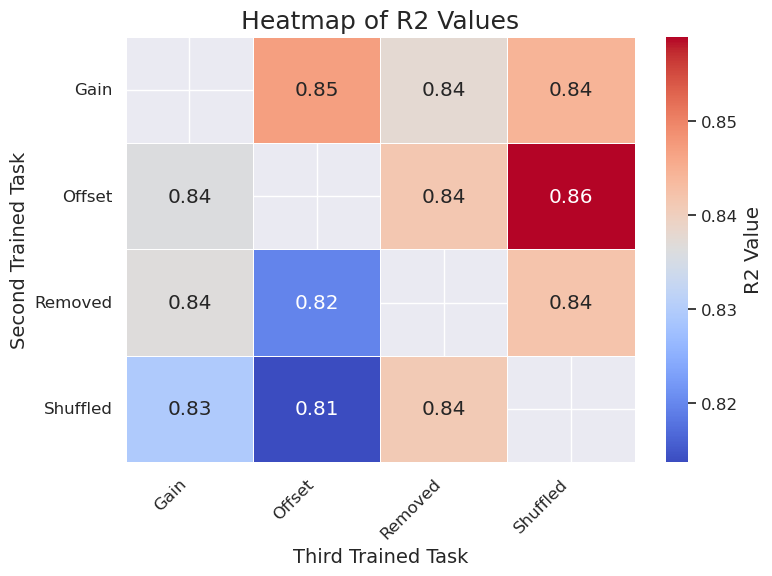

In [6]:

# Pivot the dataframe for heatmap
heatmap_data = df.pivot_table(index="Second Trained Task", columns="Third Trained Task", values="R2 Third Task")

# Generate the heatmap with enhanced styling
plt.figure(figsize=(8, 6))

sns.set(font_scale=1.2)  # Increase the font size
heatmap = sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, cbar_kws={'label': 'R2 Value'})

# Customize the heatmap for better appearance
plt.title('Heatmap of R2 Values', fontsize=18)
plt.xlabel('Third Trained Task', fontsize=14)
plt.ylabel('Second Trained Task', fontsize=14)#, weight='bold')

# Improve tick label appearance
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Adjust color bar
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

# Show the heatmap
plt.tight_layout()
plt.show()